In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount = False)

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/230E/YahooFinance_COKE_PEPSI_AdjClose_1990-2018.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
startdate = '1995-1-1'
enddate = '2014-12-31'
df = df.loc[startdate : enddate, :]
df['log_COKE'] = df['COKE'].apply(np.log)
df['log_PEP'] = df['PEP'].apply(np.log)
df['dlog_COKE'] = df['log_COKE'].diff()
df['dlog_PEP']  = df['log_PEP'].diff()
df = df.dropna()

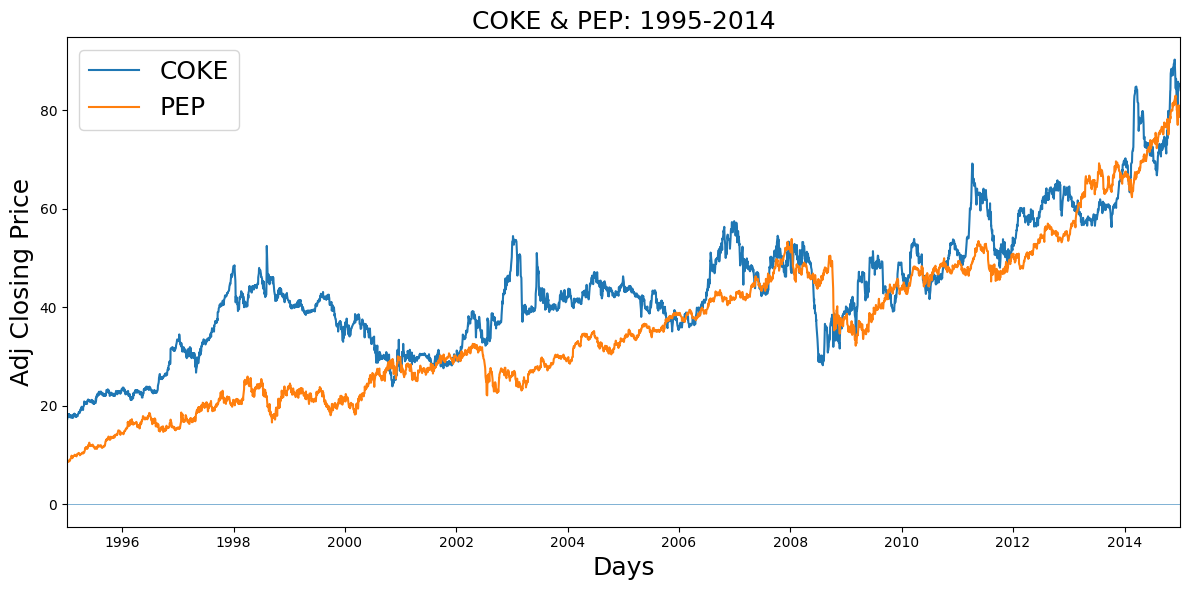

In [ ]:
fig, axes = plt.subplots(figsize = (12,6))
axes.plot(df[['COKE']], label = 'COKE')
axes.plot(df[['PEP']], label = 'PEP')

axes.set_xlim(df.index.min(), df.index.max())
axes.set_xlabel('Days', fontsize = 18)
axes.set_ylabel('Adj Closing Price', fontsize = 18)
axes.set_title('COKE & PEP: ' + str(df.index.min().year) + '-' + str(df.index.max().year), fontsize = 18)
axes.axhline(y = 0, linewidth = 0.4)
axes.legend(fontsize = 18, loc = 'best')
fig.tight_layout()

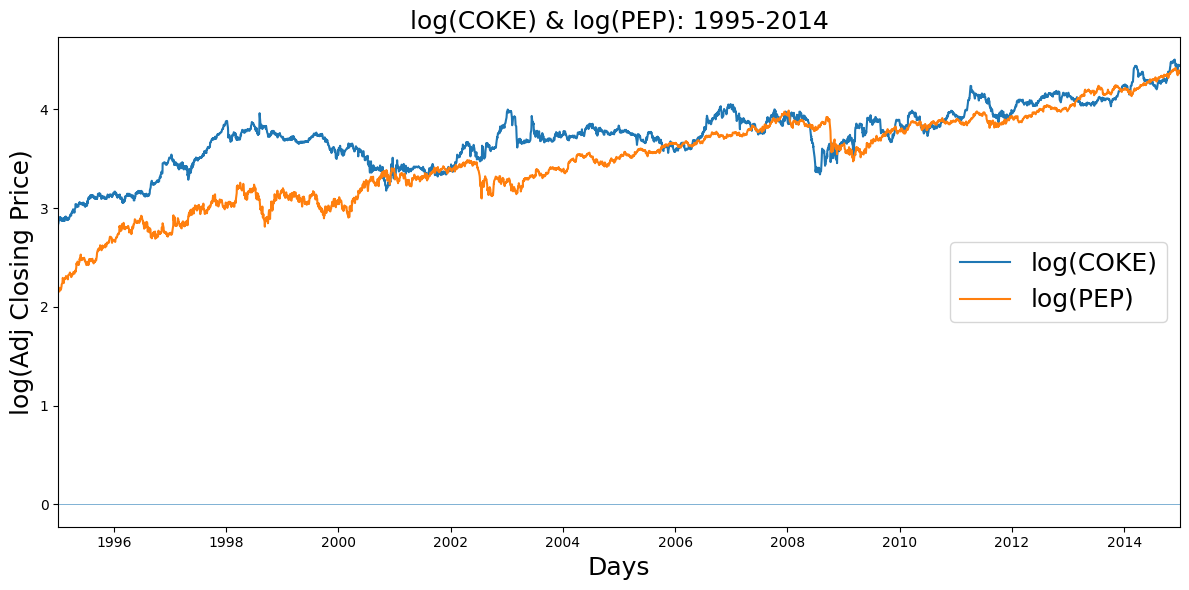

In [ ]:
fig, axes = plt.subplots(figsize = (12,6))
axes.plot(df[['log_COKE']], label = 'log(COKE)')
axes.plot(df[['log_PEP']], label = 'log(PEP)')

axes.set_xlim(df.index.min(), df.index.max())
axes.set_xlabel('Days', fontsize = 18)
axes.set_ylabel('log(Adj Closing Price)', fontsize = 18)
axes.set_title('log(COKE) & log(PEP): ' + str(df.index.min().year) + '-'
               + str(df.index.max().year), fontsize = 18)
axes.axhline(y = 0, linewidth = 0.4)
axes.legend(fontsize = 18, loc = 'best')
fig.tight_layout()

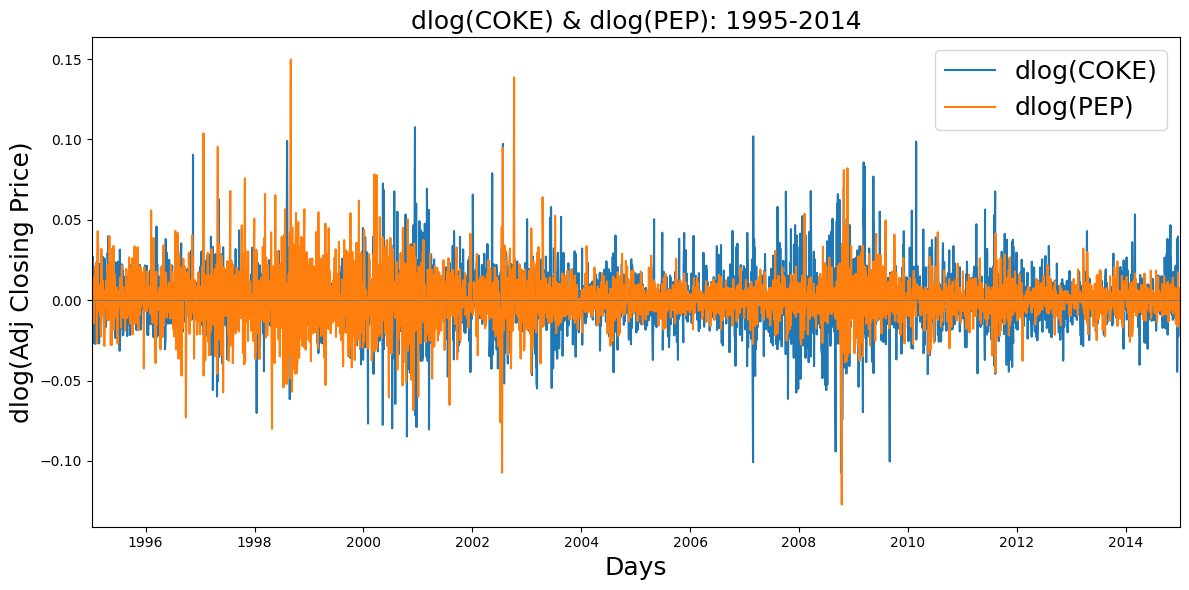

In [ ]:
fig, axes = plt.subplots(figsize = (12,6))
axes.plot(df[['dlog_COKE']], label = 'dlog(COKE)')
axes.plot(df[['dlog_PEP']], label = 'dlog(PEP)')

axes.set_xlim(df.index.min(), df.index.max())
axes.set_xlabel('Days', fontsize = 18)
axes.set_ylabel('dlog(Adj Closing Price)', fontsize = 18)
axes.set_title('dlog(COKE) & dlog(PEP): ' + str(df.index.min().year) + '-'
               + str(df.index.max().year), fontsize = 18)
axes.axhline(y = 0, linewidth = 0.4)
axes.legend(fontsize = 18, loc = 'best')
fig.tight_layout()

We can see that both stocks move together with a common trend. Moreover, for some periods, one stock is higher than the other, and vice versa. In addition, both series look $I(1)$.

Let us define $X_{1,t}$ to be the **COKE** price time series and $X_{2,t}$ the **PEP** price time series.

### Unit-root tests (Augmented Dickey-Fuller):


In [ ]:
def ADF_test(df, col_idx):
  adf_result = adfuller(df[col_idx])
  print(col_idx, ': ADF statistic (p-value): %0.3f (%0.3f)' % (adf_result[0], adf_result[1]),
        '\n\tcritical values', adf_result[4],'\n')

#### ADF test for $log(X_{1,t})\equiv log(COKE_{t})$

In [ ]:
ADF_test(df, 'log_COKE')

log_COKE : ADF statistic (p-value): -2.021 (0.278) 
	critical values {'1%': -3.4320129151078773, '5%': -2.8622747848972327, '10%': -2.5671611343964584} 



#### ADF test for $\Delta log(X_{1,t})\equiv \Delta log(COKE_{t})$

In [ ]:
ADF_test(df, 'dlog_COKE')

dlog_COKE : ADF statistic (p-value): -32.767 (0.000) 
	critical values {'1%': -3.432010803432236, '5%': -2.86227385208086, '10%': -2.567160637803087} 



#### ADF test for $log(X_{2,t})\equiv log(PEP_{t})$

In [ ]:
ADF_test(df, 'log_PEP')

log_PEP : ADF statistic (p-value): -2.154 (0.223) 
	critical values {'1%': -3.4320116474585953, '5%': -2.862274224923052, '10%': -2.567160836289042} 



#### ADF test for $\Delta log(X_{2,t})\equiv \Delta log(PEP_{t})$

In [ ]:
ADF_test(df, 'dlog_PEP')

dlog_PEP : ADF statistic (p-value): -16.830 (0.000) 
	critical values {'1%': -3.432015456217749, '5%': -2.862275907411977, '10%': -2.5671617319776505} 



The unit root tests suggest both the log of $COKE$ and $PEP$ daily prices are **nonstationary**, and more specifically $I(1)$.

Estimate the cointegrating vector $\mathbf{\alpha}$ via **Dynamic OLS** and construct the cointegration error/residual:
$$
\begin{align*}
    z_t =
    \begin{pmatrix}
        \alpha_{COKE} & \alpha_{PEP}
    \end{pmatrix}\cdot
     \begin{pmatrix}
        \log(COKE_t) \\ \log(PEP_t)
    \end{pmatrix}\  
\end{align*}      
$$


### Estimating the cointegrating vector $\mathbf{\alpha}$

Suppose we didn't know the cointegrating vector $\mathbf{\alpha}$ then, we could estimate it via:
1. **OLS**
2. **Dynamic OLS**
3. **Johansen Procedure**

#### 1. OLS
Simply regress $x_{1,t}$ on $x_{2,t}$. We obtain:
$$
\begin{align*}
    \hat{\beta}_{OLS} =
    \begin{pmatrix}
        1 & -\hat{\beta}_2
    \end{pmatrix}
\end{align*}
$$

where $\hat{\beta}_2$ is the **OLS** coefficient for $x_{2,t}$.


#### 2. Dynamic OLS

Regress $x_{1,t}$ on $x_{2,t}$, but include additional lags and leads of $\Delta x_{2,t}$:
$$
x_{1,t} = \mu + \beta_2 x_{2,t} + \sum_{j=-J}^{J} \beta_{2,j} \Delta x_{2,t-j} + \varepsilon_t
$$
and the estimated cointegrating vector is:

$$
\begin{align*}
    \hat{\beta}_{DOLS} =
    \begin{pmatrix}
    1 & -\hat{\beta}_2
    \end{pmatrix}
\end{align*}
$$   
where $\hat{\alpha}_2$ is once again the **OLS** coefficient for $x_{2,t}$.

Let us define functions that implement the **OLS** and **Dynamic OLS** estimation of $\mathbf{\alpha}$, `ols_cointegrating_vec` and `dols_cointegrating_vec`. The default number of lags and leads for the **Dynamic OLS** procedure will be *k_lags*=$5$.

#### 3. Johansen method

In [ ]:
def dols_cointegrating_vec(df_y, df_x, k_lags = 5):
  df_dx = df_x.diff(1)
  XX = df_x
  for klag in range(1, k_lags):
    xl = df_dx.shift(klag)
    xl.columns = [l + str(klag) for l in xl.columns]
    XX = pd.concat([XX, xl], axis = 1)
    xl = df_dx.shift(-klag)
    xl.columns = [l + str(-klag) for l in xl.columns]
    XX = pd.concat([XX, xl], axis = 1)
  XX = XX.iloc[k_lags : -k_lags + 1]
  Y  = df_y.iloc[k_lags : -k_lags + 1]
  dols_fit = sm.OLS(Y, sm.add_constant(XX), missing = 'drop').fit()
  dols_fit = dols_fit.get_robustcov_results(cov_type = 'HAC', maxlags = k_lags)
  beta = np.append(1, -dols_fit.params[1 : 1 + df_x.shape[1]])
  return dols_fit, beta

def get_cointegrating_vec(x1, x2, beta, remove_trend = False):
  """
  Get cointegrating error "z" from alpha,
  and check for unit root
  """
  print('Cointegrating vector: ', beta)
  X = np.c_[x1, x2]
  z = np.dot(X, beta)
  if remove_trend:
    T = np.array(range(z.shape[0]))
    z = sm.OLS(z, sm.add_constant(T)).fit().resid
  adf_result = adfuller(z)
  print('\nADF stat (p-val): %0.3f (%0.3f)' % (adf_result[0], adf_result[1]),
        '\n\tcritical values:', adf_result[4], '\n')
  return z

def my_coint(x1, x2, beta = None, dols_lags = 5):
  if beta is None:
    dols_fit, beta = dols_cointegrating_vec(x1, x2, k_lags = dols_lags)
    aeg_result = coint(x1, x2, trend = 'c', method = 'aeg', autolag = 'bic')
    print('\nAEG statistic (p-value): %0.3f (%0.3f)' % (aeg_result[0], aeg_result[1]),
          '\n(1%, 5%, 10%) critical values', aeg_result[2],'\n')
    return beta
  else:
    get_cointegrating_vec(x1, x2, beta)

                            OLS Regression Results                            
Dep. Variable:               log_COKE   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     58.39
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          1.95e-195
Time:                        04:18:15   Log-Likelihood:                 1508.0
No. Observations:                3925   AIC:                            -2976.
Df Residuals:                    3905   BIC:                            -2850.
Df Model:                          19                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7547      0.064     27.216      0.0

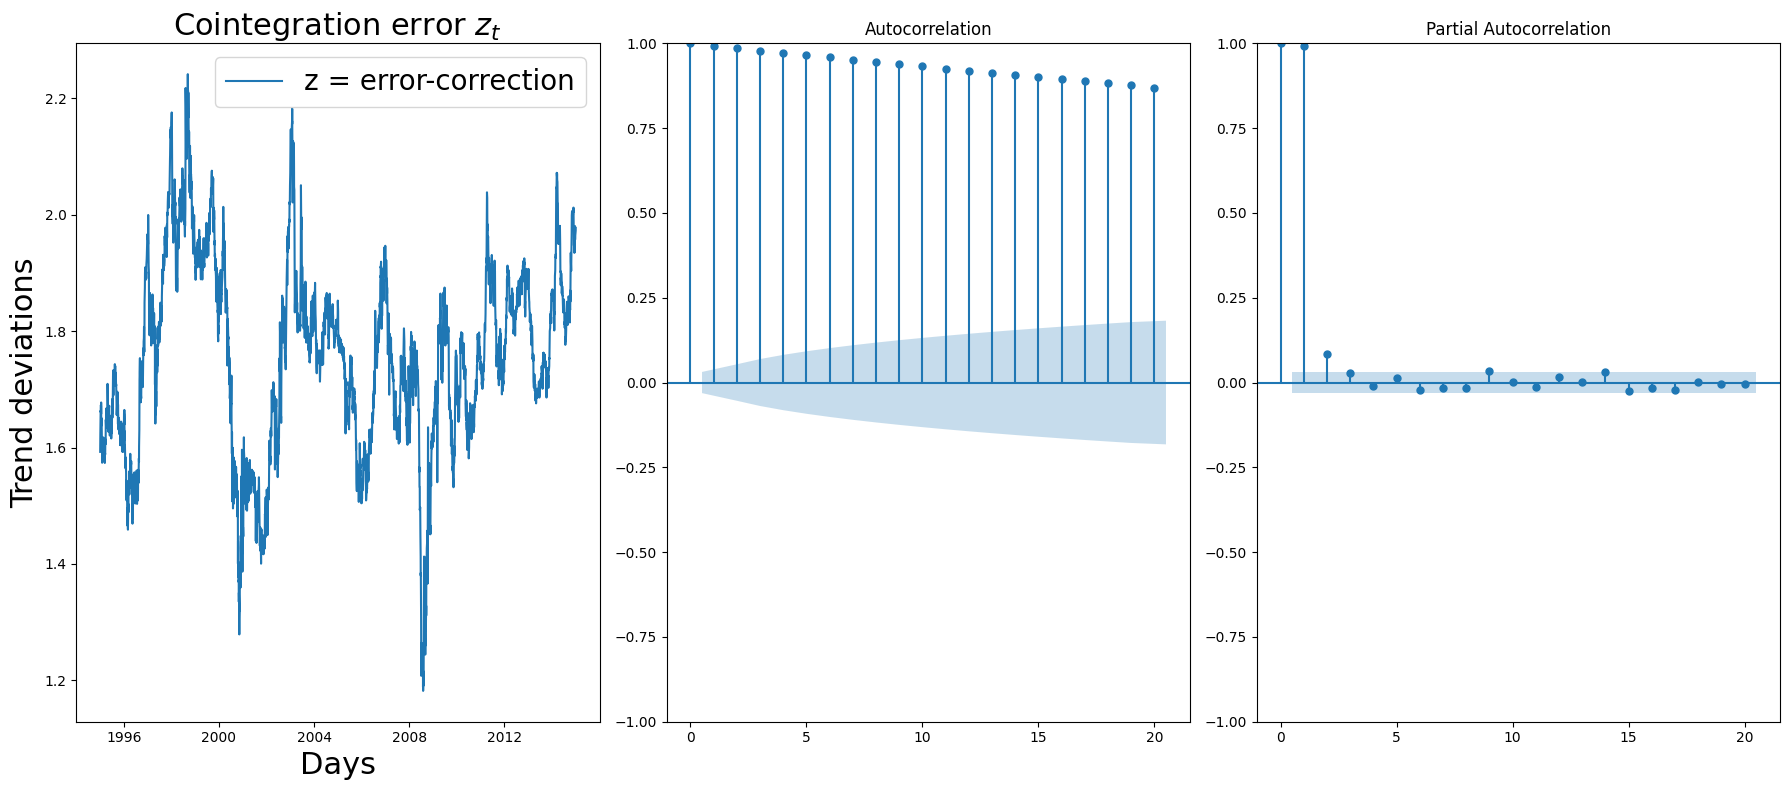

In [ ]:
x1 = df[['log_COKE']]
x2 = df[['log_PEP']]

dols_fit, beta_dols = dols_cointegrating_vec(x1, x2, k_lags = 10)
print(dols_fit.summary(), '\n')

z_dols = pd.DataFrame(get_cointegrating_vec(x1, x2, beta_dols, remove_trend = False), index = df.index, columns = ['ec'])

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 8))
axes[0].plot(z_dols['ec'], label = 'z = error-correction')
axes[0].set_title('Cointegration error $z_t$', fontsize = 22)
axes[0].set_xlabel('Days', fontsize = 22)
axes[0].set_ylabel('Trend deviations', fontsize = 22)
axes[0].legend(fontsize = 20)
plot_acf(z_dols['ec'], ax = axes[1], lags = 20)
plot_pacf(z_dols['ec'], ax = axes[2], lags = 20)
fig.tight_layout()

In [ ]:
my_coint(x1, x2, dols_lags = 10)


AEG statistic (p-value): -3.561 (0.027) 
(1%, 5%, 10%) critical values [-3.89921971 -3.33768005 -3.0455258 ] 



array([ 1.        , -0.56508975])

In [ ]:
my_coint(x1, x2, beta_dols)

Cointegrating vector:  [ 1.         -0.56508975]

ADF stat (p-val): -3.443 (0.010) 
	critical values: {'1%': -3.432010381740514, '5%': -2.8622736658017263, '10%': -2.567160538635691} 



We reject the null hypothesis $\mathbf{H}_0$ of a unit root in the cointegrating residual $z_t$ (at the 5% significance level), even though it is quite persistent.

The cointegrating vector estimate via **DOLS**, $\widehat{\beta}_{DOLS}$, is $(1, -0.562)$

### Econometric Analysis:

Let's run the **Johansen (1991)** test for cointegration. It is a procedure for testing cointegration of any $k$, $I(1)$ time series. This test permits more than one cointegrating relationship. In our case, $k=2$.

Thus, the **Johansen (1991)** test is generally more applicable than the **Augmented Engle–Granger two-step** test which is based on the **Augmented Dickey–Fuller** test for unit roots in the residuals from a single (estimated) cointegrating relationship.

There are two types of Johansen test, either with <u>trace</u> or with <u>eigenvalue</u> (inferences may be a little bit different). Cf. Luetkepohl (2005 textbook, Section 8.2.1 p. 328-329).

#### Trace test:
The null hypothesis $\mathbf{H}_0$ for the <u>trace test</u> is that the number of cointegration vectors is $r = r^* < k$, vs. the alternative $\mathbf{H}_1: r = k$. Testing proceeds sequentially for $r^* = 0, 1, 2, ...$, and the first non-rejection of the null is taken as an estimate of $r$.

#### Eigenvalue test:
The null hypothesis $\mathbf{H}_0$ for the <u>"maximum eigenvalue" test</u> is as for the trace test but the alternative $\mathbf{H}_1:r = r^* + 1$ and, again, testing proceeds sequentially for $r^* = 0, 1, 2, ...$, with the first non-rejection used as an estimator for $r$.

We will use the `statsmodels` routine [`coint_johansen`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html) that is a built-in function as part of the `VECM` class. We will include a constant term (i.e.`det_order=0`) and specify up to 2 lagged differences in the model (` k_ar_diff=2`).

if there are three variables ($K = 3$), we first test $rk(\Pi) = 0$. If this null hypothesis cannot be rejected, the analysis proceeds with a cointegration rank of $r = 0$ and, hence, a model in first differences is considered in the subsequent analysis. If, however, $rk(\Pi) = 0$ is rejected, we test $rk(\Pi) = 1$. Should the test not reject this hypothesis, the analysis may proceed with a VECM with cointegrating rank $r = 1$. Otherwise $rk(\Pi) = 2$ is tested and $r = 2$ is chosen as the cointegrating rank if this hypothesis cannot be rejected. If $rk(\Pi) = 2$ is also rejected, one may consider working with a stationary VAR model for the levels of the variables.

In [ ]:
johan_test = coint_johansen(endog = df[['log_COKE', 'log_PEP']], det_order = 0,  k_ar_diff = 2)
print('Trace = ',johan_test.lr1, '\ncv =\n ', johan_test.cvt)
print('\n\nMaxEV = ',johan_test.lr2, '\ncv =\n', johan_test.cvm)

Trace =  [16.20956729  4.14527213] 
cv =
  [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


MaxEV =  [12.06429516  4.14527213] 
cv =
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


The output above provides us with <u>trace test</u> statistic as well as the <u>"maximum eigenvalue" test</u> statistic, each at $10\%$, $5\%$, and $1\%$ critical values. (E.g. the first line of cv gives the 10\%, 5\%, 1\% critical value for the H0: $r = r^* = 0$ vs. H1: $r = k = 2$, and so on.)

The <u>trace test</u> tells us we cannot reject the null hypothesis of one cointegrating relationship against the alternative of three. Whereas the <u>"maximum eigenvalue" test</u> tells us we may reject (or close to) the null of no cointegration against the alternative of one cointegrating vector. (We reject when the trace/eigenvalue statistic is above the critival value.)

### Estimating the VECM($p$).


$$\Delta y_t = \Pi y_{t-1} + \Gamma_1 \Delta y_{t-1} + \cdots + \Gamma_{k_{ar}-1} \Delta y_{t-k_{ar}+1} + u_t$$
where $$\Pi = \alpha \beta'$$

In [ ]:
X = df[['log_COKE', 'log_PEP']]
print(select_order(X, maxlags = 10).summary())
pstar = select_order(X, maxlags = 10).bic

vecm_model = VECM(X, k_ar_diff = pstar, deterministic = 'co').fit()
alpha_vecm_statsmodels = vecm_model.alpha
beta_vecm_statsmodels = vecm_model.beta

print("Estimated alpha : ", alpha_vecm_statsmodels.flat[:])
print("Estimated beta : ", beta_vecm_statsmodels.flat[:], '\n')
print(vecm_model.summary(), '\n')

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -16.08      -16.07   1.039e-07      -16.08
1       -16.09     -16.07*   1.029e-07     -16.08*
2       -16.09      -16.07   1.028e-07      -16.08
3      -16.09*      -16.06  1.027e-07*      -16.08
4       -16.09      -16.06   1.028e-07      -16.08
5       -16.09      -16.05   1.029e-07      -16.08
6       -16.09      -16.04   1.029e-07      -16.07
7       -16.09      -16.03   1.030e-07      -16.07
8       -16.09      -16.03   1.030e-07      -16.07
9       -16.09      -16.02   1.031e-07      -16.06
10      -16.09      -16.01   1.031e-07      -16.06
--------------------------------------------------
Estimated alpha :  [-0.0059932   0.00197366]
Estimated beta :  [ 1.         -0.61705971] 

Det. terms outside the coint. relation & lagged endog. parameters for equation log_COKE
                  coef    std err          z      P>|z| 

We obtain the estimate $\widehat{\alpha}=(-0.006, 0.002)^{\prime}$ with $log(COKE_t)$ error-correcting.

### Trading Strategy:

Based on our cointegrating estimates, we could construct an operational trading strategy that shorts the stock <u>above</u> the common trend and buys the stock <u>below</u> the common trend. When the two stocks converge (here, when $log(COKE)$ error-corrects towards the common trend) we reverse our positions.

### Kalman Filter

- **State & Observation**

    - **State transition**:  
      \begin{equation*}
      \mathbf{x}_{k} = A \mathbf{x}_{k-1} + B \mathbf{u}_{k-1} + \mathbf{w}_{k-1}
      \end{equation*}
        - $A$: state transition matrix  
        - $\mathbf{w}_k \sim N(0, Q)$, where $Q$ is the process noise covariance  
        - $B$: control matrix  

    - **Observation**:  
      \begin{equation*}
      \mathbf{z}_k = H \mathbf{x}_k + \mathbf{v}_k
      \end{equation*}
        - $\mathbf{v}_k \sim N(0, R)$, where $R$ is the measurement noise covariance

---

- **Predict**

    - **Prior state**:  
      \begin{equation*}
      \hat{\mathbf{x}}_{k}^{-} = A \hat{\mathbf{x}}_{k-1} + B u_k
      \end{equation*}
      
    - **Prior state covariance**:  
      \begin{equation*}
      P_{k}^{-} = AP_{k-1}A^{\prime} + Q
      \end{equation*}

    Proof:  
    
    Given:  
    \begin{equation*}
    \mathbf{x}_k = A\mathbf{x}_{k-1} + B\mathbf{u}_{k-1} + \mathbf{w}_{k-1}
    \end{equation*}
    
    Then:  
    \begin{align*}
    \mathbf{e}_k^{-} & = \mathbf{x}_k - \hat{\mathbf{x}}_k^{-} \\
    & = A(\mathbf{x}_{k-1} - \hat{\mathbf{x}}_{k-1}) + \mathbf{w}_k \\
    & = A \mathbf{e}_{k-1} + \mathbf{w}_{k}
    \end{align*}
    
    \begin{align*}
    P_{k}^{-} &= \mathbb{E}[\mathbf{e}_k^{-} (\mathbf{e}_k^{-})^{\prime}] \\
    &= \mathbb{E}[(\mathbf{x}_k - \hat{\mathbf{x}}_k^{-})(\mathbf{x}_k - \hat{\mathbf{x}}_k^{-})^{\prime}] \\
    &= A\mathbb{E}[\mathbf{e}_{k-1}\mathbf{e}_{k-1}^{\prime}]A^{\prime} + \mathbb{E}[\mathbf{w}_k \mathbf{w}_k^{\prime}] + 2A\mathbb{E}[\mathbf{e}_{k-1} \mathbf{w}_{k}^{\prime}] \\
    &= A P_{k-1} A^{\prime} + Q
    \end{align*}

---

- **Kalman Gain**  
  \begin{equation*}
  K_k = P_k^{-} H^{\prime} \left( H P_k^{-} H^{\prime} + R \right)^{-1}
  \end{equation*}
  Minimizes the mean squared error of the updated estimate.

    Proof:
    
    - Useful identities:
      - $\frac{d \left(\text{Tr}(AB)\right)}{dA} = B^\prime$
      - $\frac{d \left(\text{Tr} (ABA^{\prime}) \right)} {dA} = 2AB$
    
    - Update equation:  
      \begin{equation*}
      \hat{\mathbf{x}}_k = \hat{\mathbf{x}}_k^{-} + K_k \left( \mathbf{z}_k - H \hat{\mathbf{x}}_k^{-} \right)
      \end{equation*}
      \begin{equation*}
      \mathbf{z}_k = H \mathbf{x}_k + \mathbf{v}_k
      \end{equation*}
    
    - Error:
      \begin{align*}
      \mathbf{e}_k &= \mathbf{x}_k - \hat{\mathbf{x}}_k \\
      &= (I - K_kH)(\mathbf{x}_k - \hat{\mathbf{x}}_k^{-}) - K_k \mathbf{v}_k
      \end{align*}
    
    - Error covariance:
      \begin{align*}
      P_k &= \mathbb{E}[\mathbf{e}_k \mathbf{e}_k^{\prime}] \\
      &= (I - K_kH)P_{k}^{-}(I - K_kH)^{\prime} + K_k RK_k^{\prime} \\
      &= P_{k}^{-} - 2K_k H P_{k}^{-} + K_k H P_k^{-} H^{\prime} K_k^{\prime} + K_k R K_k^{\prime}
      \end{align*}
    
    - Minimize trace:
      \begin{equation*}
      \frac{d \left(\text{Tr} (P_k)\right)}{d(K_k)} = -2P_k^{-} H^{\prime} + 2K_kHP_{k}^{-}H^{\prime} + 2K_k R = 0
      \end{equation*}
      \begin{equation*}
      \Rightarrow K_k = P_k^{-} H^{\prime} (HP_k^{-}H^{\prime} + R)^{-1}
      \end{equation*}

---

- **Update**

    - **State update**:  
      \begin{equation*}
      \hat{\mathbf{x}}_k = \hat{\mathbf{x}}_k^{-} + K_k \left( \mathbf{z}_k - H \hat{\mathbf{x}}_k^{-} \right)
      \end{equation*}
      
    - **Covariance update**:  
      \begin{equation*}
      P_k = \left( I - K_k H \right) P_k^{-}
      \end{equation*}

---

- **Dynamic OLS**

    \begin{align*}
    \boldsymbol{\beta}_{t+1} &= \boldsymbol{\beta}_{t} + \boldsymbol{\eta}_t \\
    \mathbf{y}_t &= \mathbf{x}_{t}^{\prime} \boldsymbol{\beta}_t + \boldsymbol{\epsilon}_t
    \end{align*}
    
    - Special case:  
      \begin{equation*}
      A = I, \quad B = 0, \quad H_t = \mathbf{x}_{t}^{\prime}
      \end{equation*}

---

- **Intuition: Driving in Fog**

    - Predict-update cycle: guess based on speed, direction, etc. → correct based on new data.
    - Balance of trust: if predictions are more reliable, trust them more; if measurements are more accurate, trust them more.
    - Recursive process: every new measurement improves the estimate of the previous ones.


In [ ]:
class KalmanFilter:
  def __init__(self, A, B, H, Q, R, x0, P0):
    """
    A: State transition matrix
    B: Control input matrix
    H: Observation matrix
    Q: Process noise covariance
    R: Measurement noise covariance
    x0: Initial state estimate
    P0: Initial error covariance
    """
    self.A = A  # State transition matrix
    self.B = B  # Control input matrix
    self.H = H  # Observation matrix
    self.Q = Q  # Process noise covariance
    self.R = R  # Measurement noise covariance
    self.x_hat = x0  # Initial state estimate
    self.P = P0  # Initial error covariance

  def predict(self, u=0):
    """
    Predict the next state and error covariance.

    u: Control input vector
    """
    # Project the state ahead
    self.x_hat_minus = np.dot(self.A, self.x_hat) + np.dot(self.B, u)
    # Project the error covariance ahead
    self.P_minus = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q

    return self.x_hat_minus

  def update(self, z):
    """
    Update the state estimate with measurement z.

    z: Measurement vector
    """
    # Compute Kalman Gain
    K = np.dot(np.dot(self.P_minus, self.H.T),
                np.linalg.inv(np.dot(np.dot(self.H, self.P_minus), self.H.T) + self.R))

    # Update the estimate with the measurement
    self.x_hat = self.x_hat_minus + np.dot(K, (z - np.dot(self.H, self.x_hat_minus)))

    # Update the error covariance
    self.P = np.dot((np.eye(self.H.shape[1]) - np.dot(K, self.H)), self.P_minus)

    return self.x_hat

  def step(self, z, u=0):
    self.predict(u)
    return self.update(z)

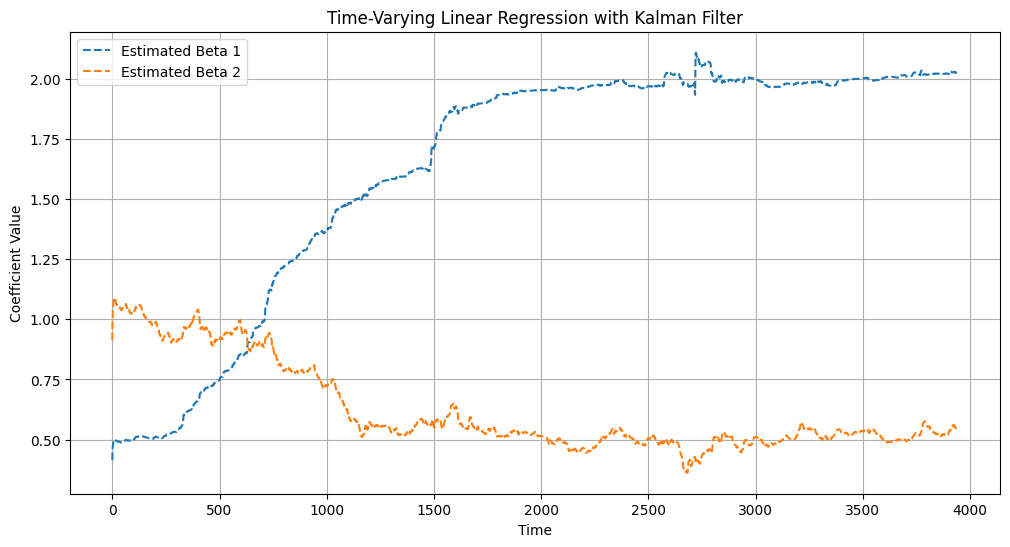

In [ ]:
# hyper-parameters
Q = 0.01 * np.eye(p)
R = 1.0

n = len(df)
p = 2

y = df['log_COKE'].values
X = df[['log_PEP']].values
X = sm.add_constant(X)

A = np.eye(p)
B = np.zeros((p, 1))
H = None
x0 = np.zeros((p, 1))
P0 = np.eye(p)

kf = KalmanFilter(A=A, B=B, H=None, Q=Q, R=R, x0=x0, P0=P0)

estimates = np.zeros((n, p))

start_time = 0

for t in range(start_time, n):
  kf.H = X[t].reshape(1, -1)
  estimates[t] = kf.step([y[t]]).flatten()

plt.figure(figsize=(12, 6))
for i in range(p):
  plt.plot(estimates[start_time:, i], label=f'Estimated Beta {i+1}', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Coefficient Value')
plt.title('Time-Varying Linear Regression with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()